# Obtaining Learning Curves for Sherbrooke and Kyoto Performance

## Sherbrooke PPO Training

In [1]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax.scipy.special import erf
from jax import jit, vmap, block_until_ready

from utils import plot_learning, photon_env_dicts

from rl_algos.ppo_continuous import PPO_make_train
from rl_algos.ppo_clipped_normal import PPO_make_train as PPO_Clipped_make_train

In [2]:
# Seeding everything

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

In [49]:
# Defining Sherbrooke Params and RL Params

tau_0 = 0.783
kappa = 14.31
chi = 0.31 * 2. * jnp.pi
kerr = 0.00
n0 = 53.8
res_amp_scaling = 1/0.348
actual_max_photons = n0 * (1. - 2. * jnp.cos(0.5 * chi * tau_0) * jnp.exp(-0.5 * kappa * tau_0) + jnp.exp(-0.5 * kappa * tau_0))
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.05
snr_scale_factor = 1.25
gamma_I = 1/362.9
photon_gamma = 1/4000
init_fid = 1.

time_coeff = 1.0
snr_coeff = 20.0
smoothness_coeff = 0.1
smoothness_baseline_scale = 1.0
gauss_kernel_len = 15
gauss_kernel_std = 2.0
bandwidth = 50.0
freq_relative_cutoff = 0.1
bandwidth_coeff = 0.0
num_t1 = 9.0
photon_weight = 12.0
shot_noise_std = 0.0
standard_fid = 0.99

env_config = {"kappa": kappa,
    "chi": chi,
    "kerr": kerr,
    "time_coeff": time_coeff,
    "snr_coeff": snr_coeff,
    "smoothness_coeff": smoothness_coeff,
    "smoothness_baseline_scale": smoothness_baseline_scale,
    "gauss_kernel_len": gauss_kernel_len,
    "gauss_kernel_std": gauss_kernel_std,
    "bandwidth": bandwidth,
    "freq_relative_cutoff": freq_relative_cutoff,
    "bandwidth_coeff": bandwidth_coeff,
    "n0": n0,
    "tau_0": tau_0,
    "res_amp_scaling": res_amp_scaling,
    "nR": nR,
    "snr_scale_factor": snr_scale_factor,
    "gamma_I": gamma_I,
    "photon_gamma": photon_gamma,
    "num_t1": num_t1,
    "init_fid": init_fid,
    "photon_weight": photon_weight,
    "standard_fid": standard_fid,
    "shot_noise_std": shot_noise_std,
}

num_envs = 256
num_updates = 5000
config = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "single_langevin_env",
    "ENV_PARAMS": env_config,
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 53.8
Actual Max Photons: 53.711451977836106


In [50]:
from utils import photon_env_dicts

env = photon_env_dicts()[config["ENV_NAME"]](**config["ENV_PARAMS"])

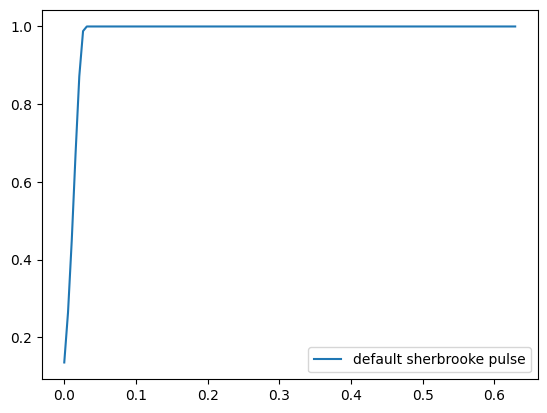

In [5]:
# Default Sherbrooke Action

ts = env.ts_action

gauss_sigma = 0.0142
num_sigma = 2.
total_duration = tau_0

default_pulse = jnp.heaviside((total_duration - num_sigma * gauss_sigma) - ts, 1.) * jnp.heaviside(ts - num_sigma * gauss_sigma, 0.)
default_pulse += jnp.heaviside(num_sigma * gauss_sigma - ts, 1.) * jnp.exp(-(ts - num_sigma * gauss_sigma)**2 / (2 * gauss_sigma**2))
default_pulse += jnp.heaviside(ts - (total_duration - num_sigma * gauss_sigma), 1.) * jnp.exp(-(ts - (total_duration - num_sigma * gauss_sigma))**2 / (2 * gauss_sigma**2))

plt.plot(ts, default_pulse, label='default sherbrooke pulse')
plt.legend()
plt.show()

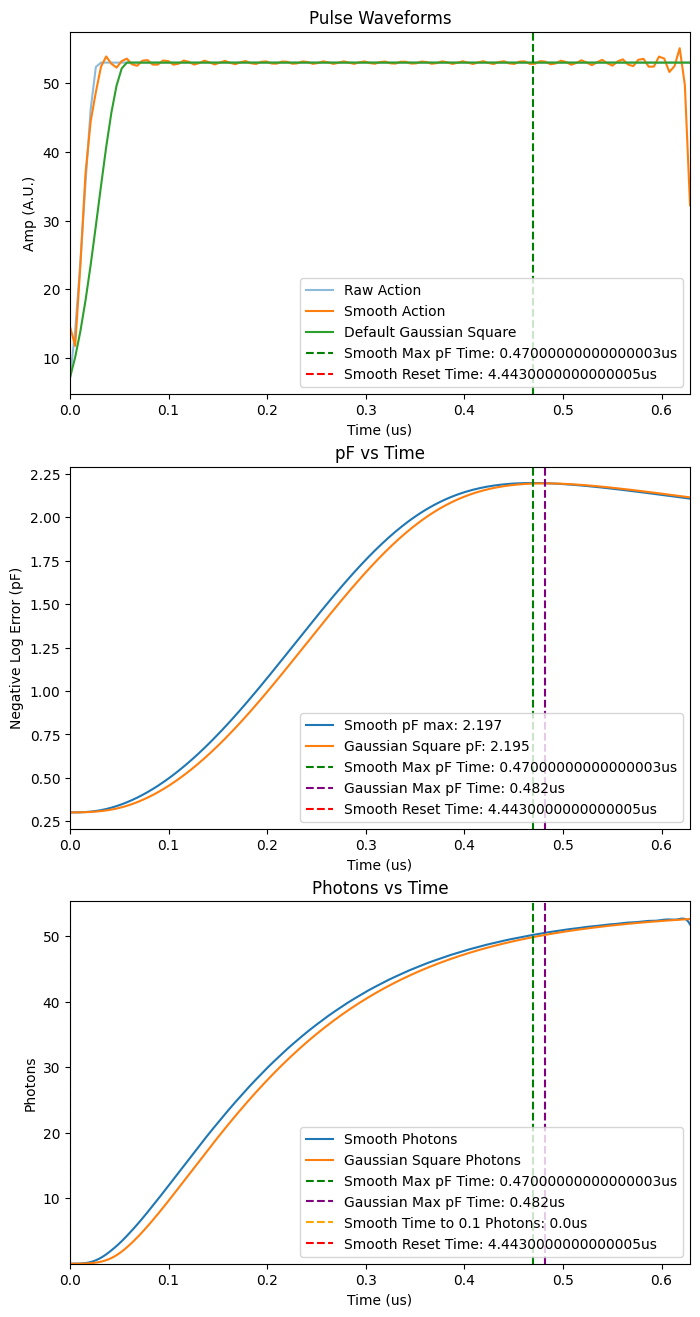

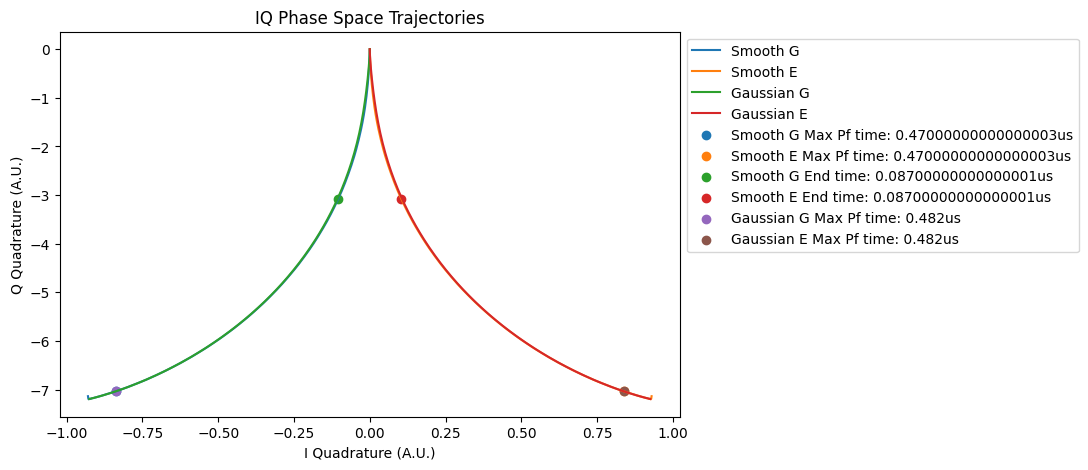

In [6]:
env.rollout_action(_rng, default_pulse)

In [8]:
single_train = jit(PPO_make_train(config), static_argnums=-1)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result = single_train(
    _rng, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 5000 Updates
global update: 100
reward: 114.261
max pF: 1.774
max photon: 44.778
photon time: 0.776
smoothness: 0.00866
bandwidth: 43.438
pulse reset val: 0.28600000000000003
global update: 200
reward: 117.519
max pF: 1.824
max photon: 45.166000000000004
photon time: 0.6947
smoothness: 0.008714999999999999
bandwidth: 41.824
pulse reset val: 0.269
global update: 300
reward: 119.066
max pF: 1.866
max photon: 46.051
photon time: 0.676
smoothness: 0.008782
bandwidth: 42.175000000000004
pulse reset val: 0.255
global update: 400
reward: 120.095
max pF: 1.927
max photon: 47.445
photon time: 0.6698000000000001
smoothness: 0.009448
bandwidth: 43.702
pulse reset val: 0.256
global update: 500
reward: 122.932
max pF: 1.947
max photon: 48.084
photon time: 0.6607000000000001
smoothness: 0.008773
bandwidth: 42.6
pulse reset val: 0.212
global update: 600
reward: 124.155
max pF: 1.996
max photon: 49.333
photon time: 0.6874
smoothness: 0.009236
bandwidth: 43.0
pulse reset val: 0.205000

In [51]:
# Extracting Results

metrics = single_result["metrics"]

rewards = metrics["reward"]
max_pFs = metrics["max pF"]
max_photons = metrics["max photon"]
photon_times = metrics["photon time"]
smoothnesses = metrics["smoothness"]
bandwidths = metrics["bandwidth"]
actions = metrics["action"]
amps = metrics["pulse reset val"]

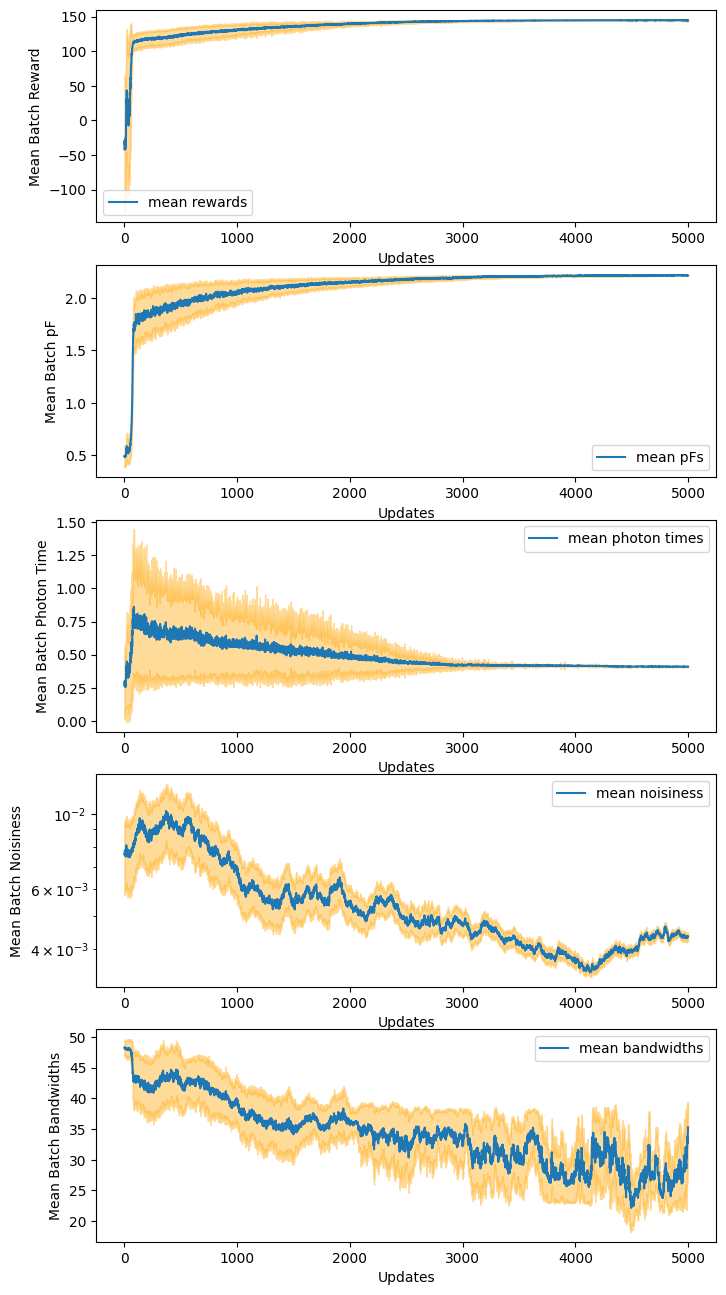

In [10]:
plot_learning(
    rewards=rewards,
    max_pFs=max_pFs,
    photon_times=photon_times,
    smoothnesses=smoothnesses,
    bandwidths=bandwidths,
)

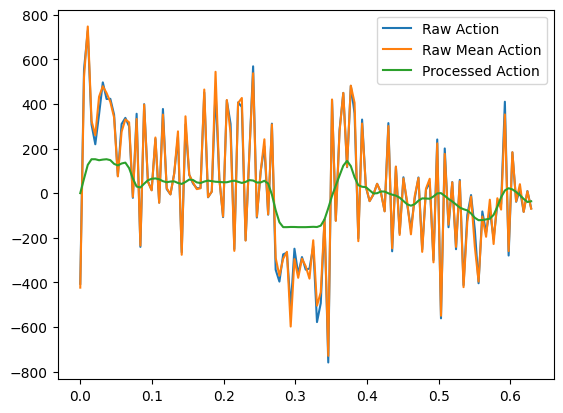

In [52]:
final_action = -actions[-1, 0]
mean_action = jnp.mean(-actions[-1], axis=0)
final_processed_action = env.prepare_action(final_action)

plt.plot(env.ts_action, final_action * env.a0, label='Raw Action')
plt.plot(env.ts_action, mean_action * env.a0, label='Raw Mean Action')
plt.plot(env.ts_action, final_processed_action, label='Processed Action')
plt.legend()
plt.show()

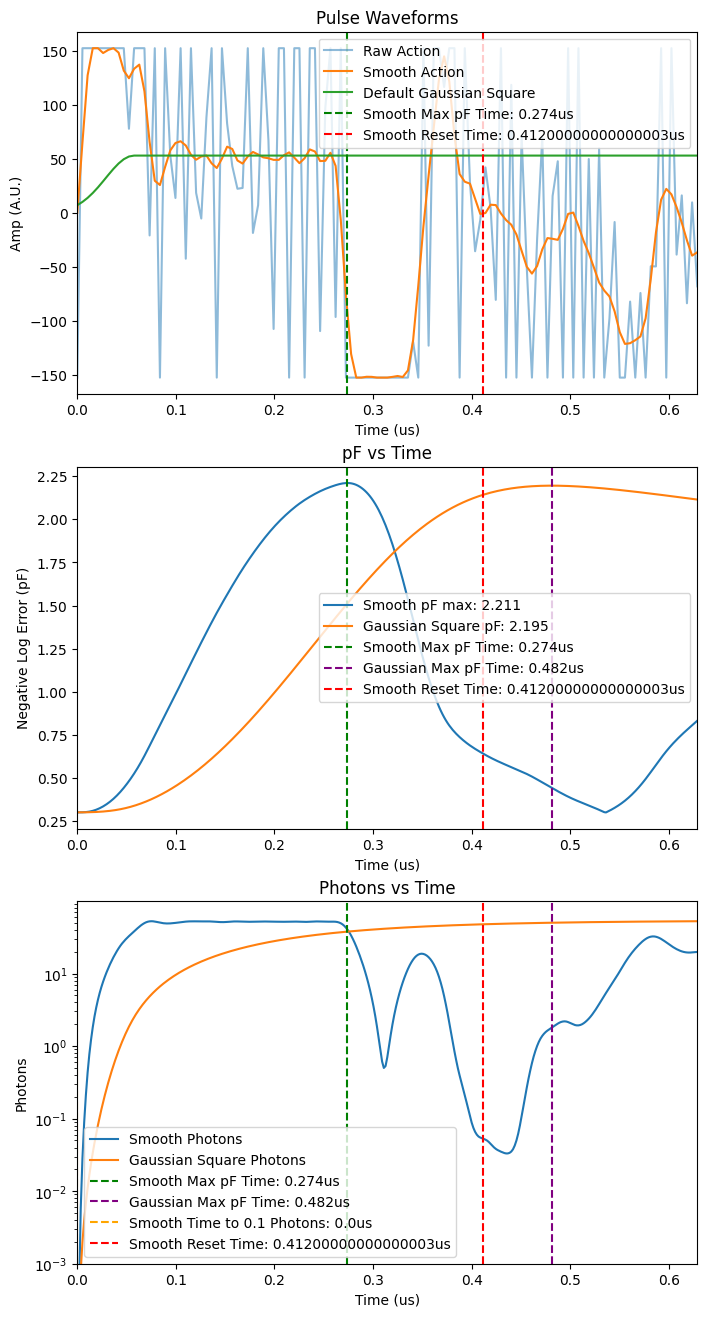

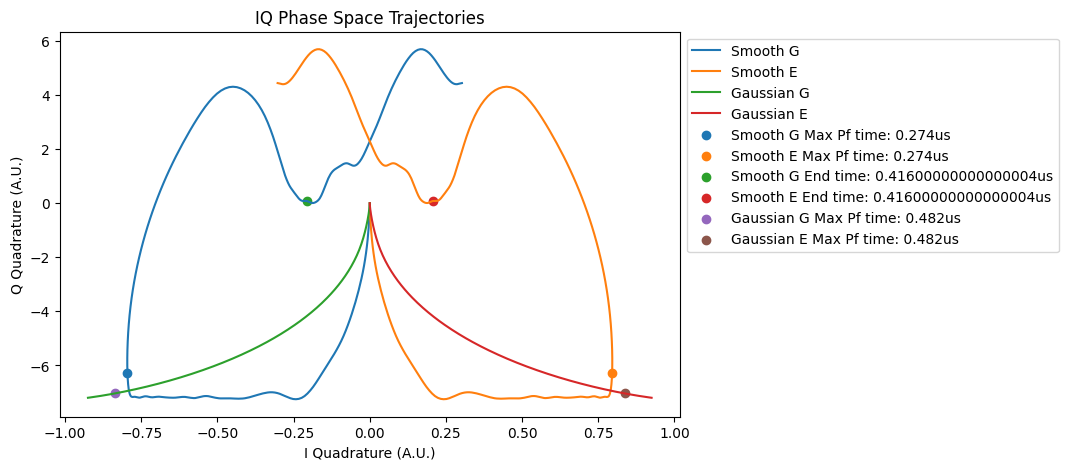

In [12]:
env.rollout_action(_rng, final_action, photon_log_scale=True)

In [13]:
pf_reward = env.pf_reward(max_pFs)
time_reward = env.time_reward(photon_times)
smoothness_reward = env.smoothness_reward(smoothnesses)
amp_reward = env.amp_reward(amps)
opt_action = final_processed_action
action_ts = env.ts_action

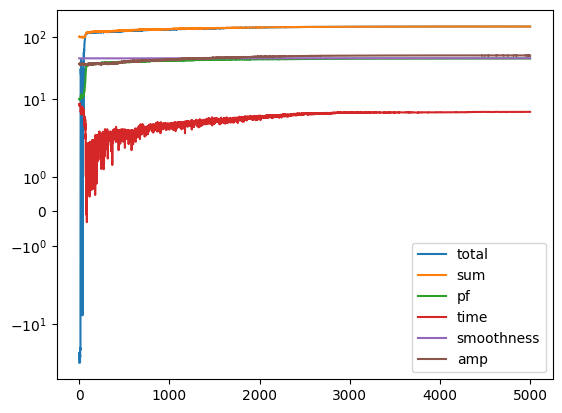

In [14]:
mean_pf_reward = jnp.mean(pf_reward, axis=-1)
mean_time_reward = jnp.mean(time_reward, axis=-1)
mean_smoothness_reward = jnp.mean(smoothness_reward, axis=-1)
mean_amp_reward = jnp.mean(amp_reward, axis=-1)
mean_sum_reward = mean_pf_reward + mean_time_reward + mean_smoothness_reward + mean_amp_reward
mean_reward = jnp.mean(rewards, axis=-1)

plt.plot(mean_reward, label='total')
plt.plot(mean_sum_reward, label='sum')
plt.plot(mean_pf_reward, label='pf')
plt.plot(mean_time_reward, label='time')
plt.plot(mean_smoothness_reward, label='smoothness')
plt.plot(mean_amp_reward, label='amp')
plt.legend()
plt.yscale('symlog')
plt.show()

## Kyoto Training

In [29]:
# Defining Kyoto Params and RL Params

tau_0 = 0.720
kappa = 10.07
chi = 0.92 * 2. * jnp.pi
kerr = 0.002
n0 = 25.5
res_amp_scaling = 1/0.51
actual_max_photons = n0 * (1. - 2. * jnp.cos(0.5 * chi * tau_0) * jnp.exp(-0.5 * kappa * tau_0) + jnp.exp(-0.5 * kappa * tau_0))
actual_max_photons = 25.5
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.1
snr_scale_factor = 0.6
gamma_I = 1/286
photon_gamma = 1/1200
init_fid = 1.

time_coeff = 1.0
snr_coeff = 20.0
smoothness_coeff = 0.01
smoothness_baseline_scale = 0.5
gauss_kernel_len = 15
gauss_kernel_std = 2.0
bandwidth = 50.0
freq_relative_cutoff = 0.1
bandwidth_coeff = 0.0
num_t1 = 6.0
photon_weight = 8.0
shot_noise_std = 0.0
standard_fid = 0.99

env_config = {"kappa": kappa,
    "chi": chi,
    "kerr": kerr,
    "time_coeff": time_coeff,
    "snr_coeff": snr_coeff,
    "smoothness_coeff": smoothness_coeff,
    "smoothness_baseline_scale": smoothness_baseline_scale,
    "gauss_kernel_len": gauss_kernel_len,
    "gauss_kernel_std": gauss_kernel_std,
    "bandwidth": bandwidth,
    "freq_relative_cutoff": freq_relative_cutoff,
    "bandwidth_coeff": bandwidth_coeff,
    "n0": n0,
    "tau_0": tau_0,
    "res_amp_scaling": res_amp_scaling,
    "nR": nR,
    "snr_scale_factor": snr_scale_factor,
    "gamma_I": gamma_I,
    "photon_gamma": photon_gamma,
    "num_t1": num_t1,
    "init_fid": init_fid,
    "photon_weight": photon_weight,
    "standard_fid": standard_fid,
    "shot_noise_std": shot_noise_std,
}

num_envs = 256
num_updates = 5000
kyoto_config = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 128,
    "ENV_NAME": "single_langevin_env",
    "ENV_PARAMS": env_config,
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 25.5
Actual Max Photons: 25.5


In [30]:
kyoto_env = photon_env_dicts()[kyoto_config["ENV_NAME"]](**kyoto_config["ENV_PARAMS"])

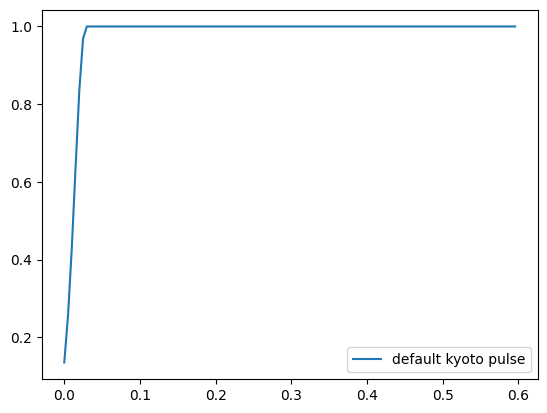

In [31]:
# Default Kyoto Action

ts = kyoto_env.ts_action

gauss_sigma = 0.0142
num_sigma = 2.
total_duration = tau_0

default_pulse = jnp.heaviside((total_duration - num_sigma * gauss_sigma) - ts, 1.) * jnp.heaviside(ts - num_sigma * gauss_sigma, 0.)
default_pulse += jnp.heaviside(num_sigma * gauss_sigma - ts, 1.) * jnp.exp(-(ts - num_sigma * gauss_sigma)**2 / (2 * gauss_sigma**2))
default_pulse += jnp.heaviside(ts - (total_duration - num_sigma * gauss_sigma), 1.) * jnp.exp(-(ts - (total_duration - num_sigma * gauss_sigma))**2 / (2 * gauss_sigma**2))

plt.plot(ts, default_pulse, label='default kyoto pulse')
plt.legend()
plt.show()

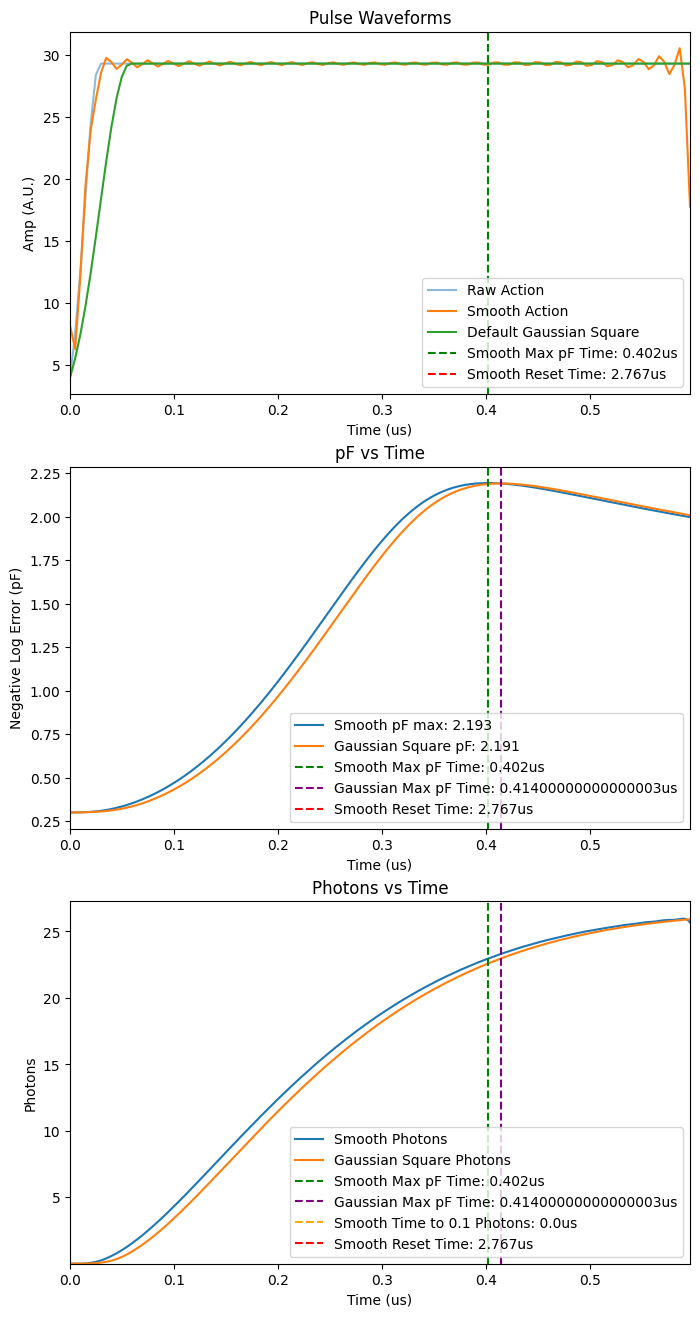

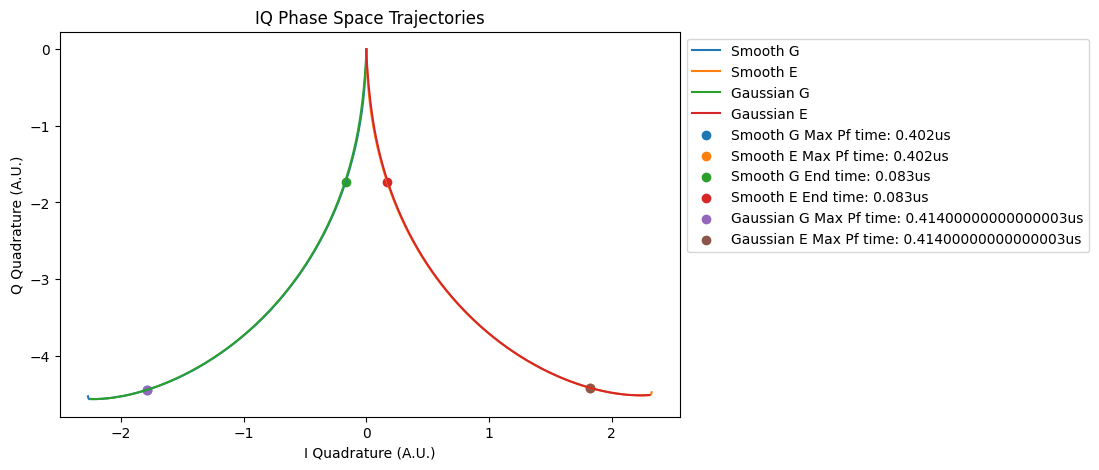

In [32]:
kyoto_env.rollout_action(_rng, default_pulse)

In [33]:
kyoto_train = jit(PPO_make_train(kyoto_config), static_argnums=-1)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
kyoto_result = kyoto_train(
    _rng, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 5000 Updates
global update: 100
reward: 83.406
max pF: 2.043
max photon: 22.128
photon time: 1.165
smoothness: 0.014223
bandwidth: 39.778
pulse reset val: 0.25
global update: 200
reward: 89.559
max pF: 2.13
max photon: 22.645
photon time: 1.1266
smoothness: 0.016815999999999998
bandwidth: 39.967
pulse reset val: 0.17500000000000002
global update: 300
reward: 93.179
max pF: 2.137
max photon: 22.762
photon time: 0.8791
smoothness: 0.014256
bandwidth: 38.114000000000004
pulse reset val: 0.151
global update: 400
reward: 96.146
max pF: 2.16
max photon: 23.417
photon time: 0.8833000000000001
smoothness: 0.015262999999999999
bandwidth: 37.658
pulse reset val: 0.107
global update: 500
reward: 99.384
max pF: 2.1710000000000003
max photon: 23.463
photon time: 0.7019000000000001
smoothness: 0.017844
bandwidth: 36.989000000000004
pulse reset val: 0.088
global update: 600
reward: 100.998
max pF: 2.194
max photon: 24.153000000000002
photon time: 0.6307
smoothness: 0.018855
bandwidt

In [34]:
# Extracting Results

k_metrics = kyoto_result["metrics"]

k_rewards = k_metrics["reward"]
k_max_pFs = k_metrics["max pF"]
k_max_photons = k_metrics["max photon"]
k_photon_times = k_metrics["photon time"]
k_smoothnesses = k_metrics["smoothness"]
k_bandwidths = k_metrics["bandwidth"]
k_actions = k_metrics["action"]
k_amps = k_metrics["pulse reset val"]

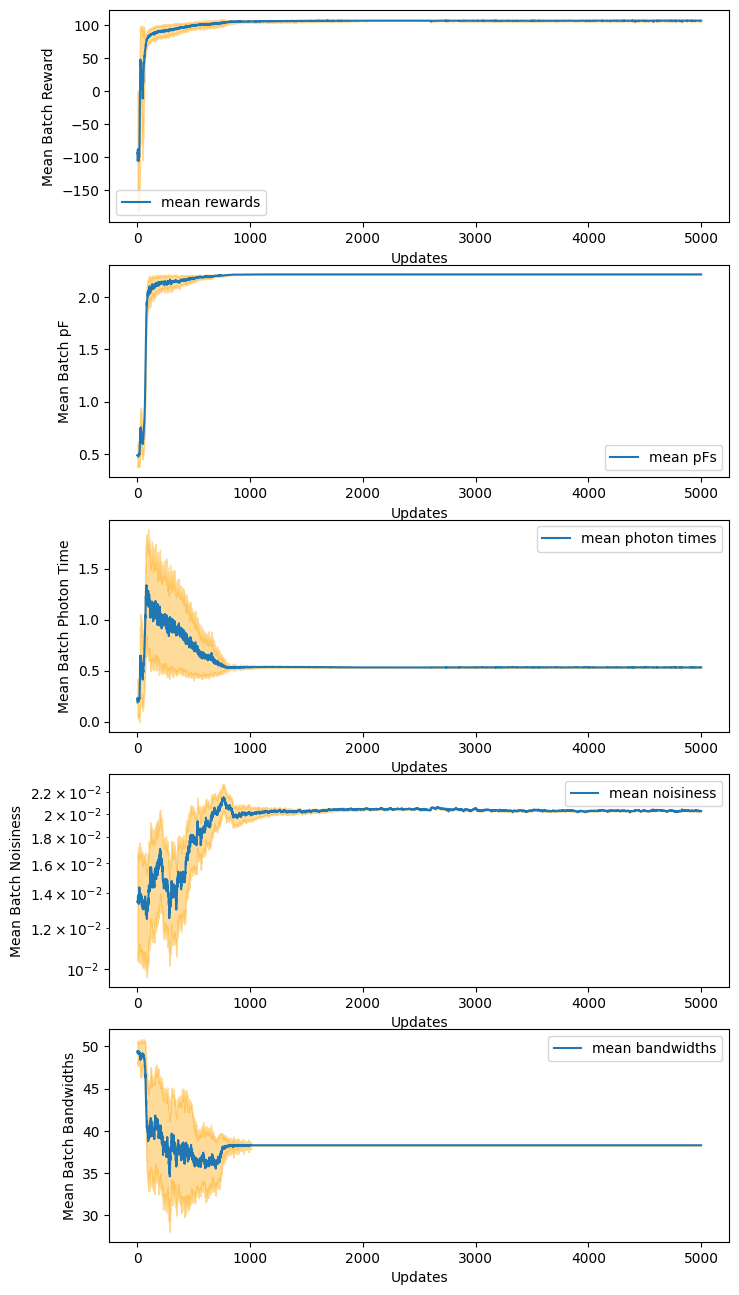

In [35]:
plot_learning(
    rewards=k_rewards,
    max_pFs=k_max_pFs,
    photon_times=k_photon_times,
    smoothnesses=k_smoothnesses,
    bandwidths=k_bandwidths,
)

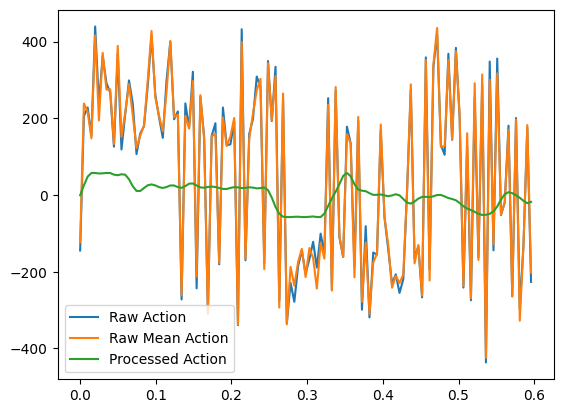

In [36]:
k_final_action = k_actions[-1, 0]
k_mean_action = jnp.mean(k_actions[-1], axis=0)
k_final_processed_action = kyoto_env.prepare_action(final_action)

plt.plot(kyoto_env.ts_action, k_final_action * kyoto_env.a0, label='Raw Action')
plt.plot(kyoto_env.ts_action, k_mean_action * kyoto_env.a0, label='Raw Mean Action')
plt.plot(kyoto_env.ts_action, k_final_processed_action, label='Processed Action')
plt.legend()
plt.show()

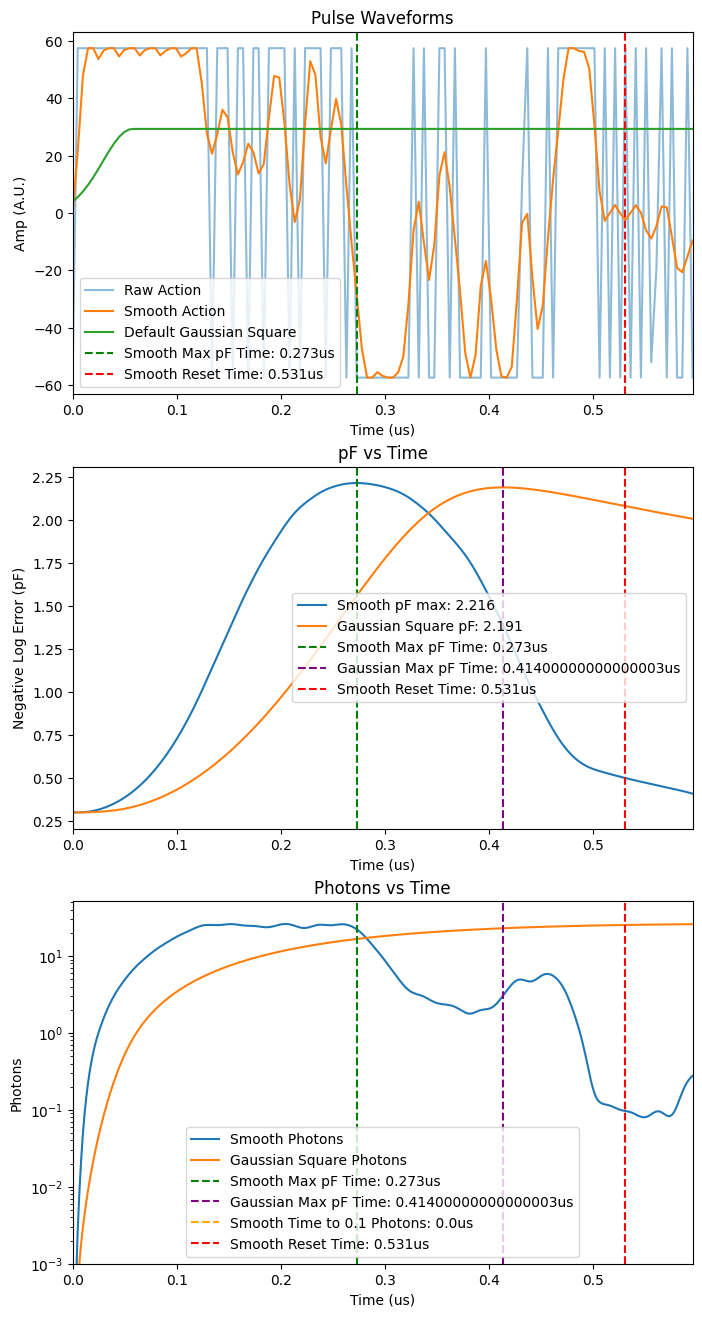

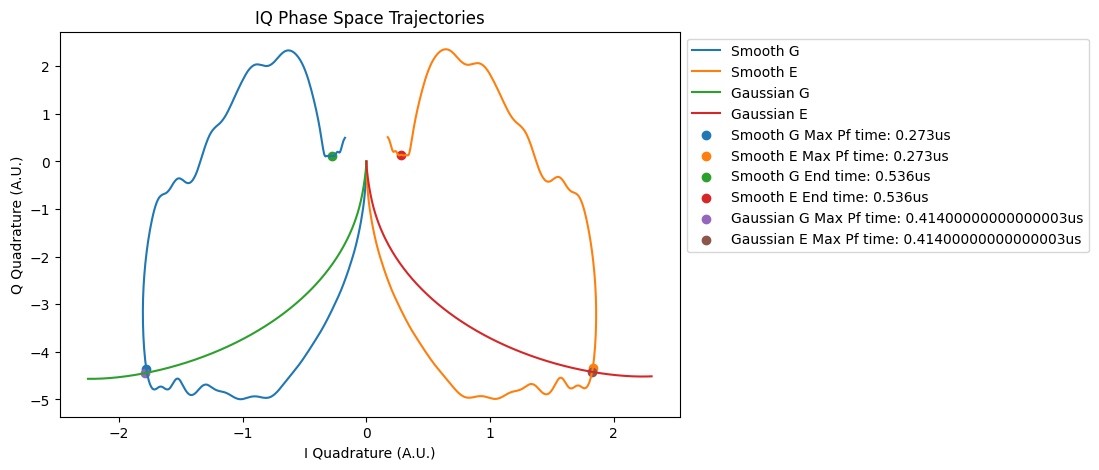

In [37]:
kyoto_env.rollout_action(_rng, k_final_action, photon_log_scale=True)

In [38]:
k_pf_reward = kyoto_env.pf_reward(k_max_pFs)
k_time_reward = kyoto_env.time_reward(k_photon_times)
k_smoothness_reward = kyoto_env.smoothness_reward(k_smoothnesses)
k_amp_reward = kyoto_env.amp_reward(k_amps)

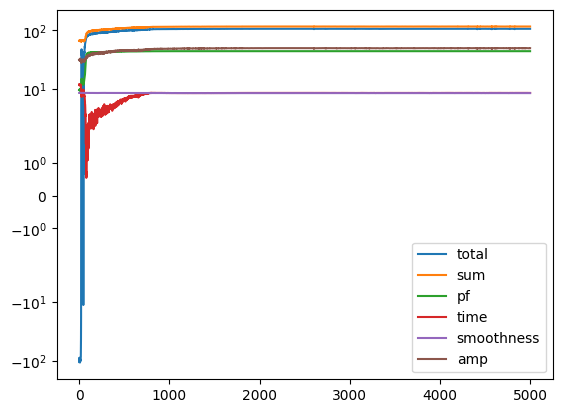

In [43]:
k_mean_pf_reward = jnp.mean(k_pf_reward, axis=-1)
k_mean_time_reward = jnp.mean(k_time_reward, axis=-1) + 5.0
k_mean_smoothness_reward = jnp.mean(k_smoothness_reward, axis=-1)
k_mean_amp_reward = jnp.mean(k_amp_reward, axis=-1)
k_mean_sum_reward = k_mean_pf_reward + k_mean_time_reward + k_mean_smoothness_reward + k_mean_amp_reward + 5.0
k_mean_reward = jnp.mean(k_rewards, axis=-1)

plt.plot(k_mean_reward, label='total')
plt.plot(k_mean_sum_reward, label='sum')
plt.plot(k_mean_pf_reward, label='pf')
plt.plot(k_mean_time_reward, label='time')
plt.plot(k_mean_smoothness_reward, label='smoothness')
plt.plot(k_mean_amp_reward, label='amp')
plt.yscale('symlog')
plt.legend()
plt.show()

In [44]:
# saving sherbrooke data
sherbrooke_reward_array = jnp.concatenate(
    (
        rewards.reshape(1, *rewards.shape),
        pf_reward.reshape(1, *pf_reward.shape),
        time_reward.reshape(1, *time_reward.shape),
        smoothness_reward.reshape(1, *smoothness_reward.shape),
        amp_reward.reshape(1, *amp_reward.shape),
    ),
    axis=0
)
np.save("fig 2 sherbrooke rewards", sherbrooke_reward_array)

In [45]:
# saving kyoto data
kyoto_reward_array = jnp.concatenate(
    (
        k_rewards.reshape(1, *k_rewards.shape),
        k_pf_reward.reshape(1, *k_pf_reward.shape),
        k_time_reward.reshape(1, *k_time_reward.shape),
        k_smoothness_reward.reshape(1, *k_smoothness_reward.shape),
        k_amp_reward.reshape(1, *k_amp_reward.shape),
    ),
    axis=0
)
np.save("fig 2 kyoto rewards", kyoto_reward_array)

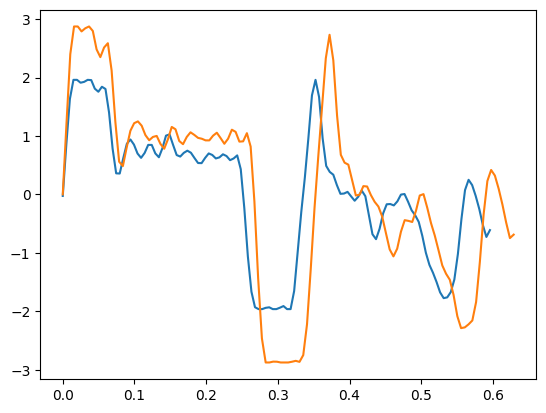

In [48]:
save_kyoto_waveform = k_final_processed_action / kyoto_env.a0
save_sherbrooke_waveform = final_processed_action / env.a0
plt.plot(kyoto_env.ts_action, save_kyoto_waveform)
plt.plot(env.ts_action, save_sherbrooke_waveform)

In [53]:
import pandas as pd

opt_sherbrooke_kyoto_waveforms = jnp.concatenate(
    (
        save_sherbrooke_waveform.reshape(1, -1),
        env.ts_action.reshape(1, -1),
        save_kyoto_waveform.reshape(1, -1),
        kyoto_env.ts_action.reshape(1, -1)
    ),
    axis=0
)
np.save("fig 2 actions", opt_sherbrooke_kyoto_waveforms)